# **Microplane Theory: Normal Tangential localization**

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D_compression
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy
import time

In [2]:
def get_omega_N(m):
    omega_N_11 = np.zeros((len(m.hist.state_vars),8))
    sigma_N_11 = np.zeros_like(omega_N_11)
    for i in range(len(m.hist.state_vars)):
        omega_N_11[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        sigma_N_11[i] = np.array([ m.hist.state_vars[i][0]['sigma_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_N_01 = np.zeros((len(m.hist.state_vars),8))
    sigma_N_01 = np.zeros_like(omega_N_01)
    for i in range(len(m.hist.state_vars)):
        omega_N_01[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,4,5,20,21,24,25]])
        sigma_N_01[i] = np.array([ m.hist.state_vars[i][0]['sigma_N_Emn'][0,0][j] for j in [0,1,4,5,20,21,24,25]])
    return omega_N_01, omega_N_11, sigma_N_01, sigma_N_11  

In [3]:
def get_omega_T(m):
    omega_T_11 = np.zeros((len(m.hist.state_vars),8))
    sigma_T_11 = np.zeros_like(omega_T_11)
    for i in range(len(m.hist.state_vars)):
        omega_T_11[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        sigma_T_11[i] = np.linalg.norm(np.array([m.hist.state_vars[i][0]['sigma_T_Emna'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]]), axis = -1)
        
    omega_T_01 = np.zeros((len(m.hist.state_vars),20))
    sigma_T_01 = np.zeros_like(omega_T_01)
    for i in range(len(m.hist.state_vars)):
        omega_T_01[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        sigma_T_01[i] = np.linalg.norm(np.array([m.hist.state_vars[i][0]['sigma_T_Emna'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]]), axis = -1)
       
    return omega_T_01, omega_T_11, sigma_T_01, sigma_T_11

# Simple damage

## Normal damage

In [18]:
# Reference parameters

mat_param =  dict(E = 37e+3, 
        nu = 0.2, 
        Ad_tension = 800.0, 
        eps_0_tension = 1e-5,
        Ad_compression = 500.0, 
        eps_0_compression = 1e-3,
        K_N = 14000.,   
        sigma_N_0 = 25.,
        gamma_N = 8000.,  
        sigma_T_0 = 2.2, 
        K_T = 1200.0, 
        gamma_T = 65000,
        S_T = 0.0027,   
        c_T = 8.7, 
        r_T = 9.2,   
        m_T = 0.0, 
        p_T = 7.5)

### Unit element tension - PVW

In [49]:
size_x = 10
size_y = 10
size_z = 10
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW_damage(**mat_param)
m_tension_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [50]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [51]:
w_max = 0.03

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [52]:
m_tension_PVW.bc=bc1

m_tension_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_tension_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
# s.run()
start = time.time()
s.run()
# try:
#     s.run()
# except:
#     # m_list_monotnonic.append(m)
#     pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 15.654632806777954 s


In [53]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_tensile_PVW = np.average(m_tension_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_tensile_PVW = np.sum(m_tension_PVW.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_tensile_PVW)))

ax1.plot(U_tensile_PVW, F_tensile_PVW/(size_x * size_y))
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_tension_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_tension_PVW.hist.state_vars),8))
for i in range(len(U_tensile_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_macro']])

# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax2.plot(U_tensile_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()




Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
plt.style.use('default')

# plt.tight_layout()

cm = 1/2.54  # centimeters in inches
fig, ((ax1,ax2,ax3, ax4), (ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(20*cm, 10*cm))

# txt=str(CAxisymm)



# plt.rcParams["font.family"] = "Times New Roman"
 
    
U_tensile_PVW = np.average(m_tension_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_tensile_PVW = -np.sum(m_tension_PVW.hist.F_t[:, compression_dofs], axis=-1)

U_lateral = m_tension_PVW.hist.U_t[:, slide_dofs]

total_work_microplane_PVW = np.zeros((len(m_tension_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_tension_PVW.hist.state_vars),8))
for i in range(len(U_tensile_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_macro']])


ax1.plot(U_tensile_PVW, F_tensile_PVW)
ax1.set_ylabel('stress [MPa]', fontsize=10)
ax1.set_xlabel('strain [-]', fontsize=10)

ax2.plot(U_tensile_PVW, U_lateral[:,0]/U_tensile_PVW)
ax2.set_ylabel('lateral strain [-]', fontsize=10)
ax2.set_xlabel('strain [-]', fontsize=10)

ax3.plot(U_tensile_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax3.set_ylabel('work macro - work micro [J/m]', fontsize=10)
ax3.set_xlabel('strain [-]', fontsize=10)


omega_N_01, omega_N_11 = get_omega_N(m_tension_PVW) 
ax5.plot(U_tensile_PVW, omega_N_11)
ax5.set_ylabel('normal damage, radial driection', fontsize=10)
ax5.set_xlabel('slip [mm]', fontsize=10)
# ax5.set_ylim(-0.05,1.05)


ax6.plot(U_tensile_PVW, omega_N_01, label='shear damage')
ax6.set_ylabel('normal damage rest', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)
# ax6.set_ylim(-0.05,1.05)

omega_T_01, omega_T_11 = get_omega_T(m_tension_PVW) 
ax7.plot(U_tensile_PVW, omega_T_11)
ax7.set_ylabel('tg damage, radial driection', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)
# ax7.set_ylim(-0.05,1.05)


ax8.plot(U_tensile_PVW, omega_T_01, label='shear damage')
ax8.set_ylabel('tg damage rest', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
# ax8.set_ylim(-0.05,1.05)
    

left  = 0.05  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

ValueError: too many values to unpack (expected 2)

### Unit element compression - PVW

In [19]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13D_compression(**mat_param)
m_compression_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [20]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [29]:
w_max = -0.01

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [30]:
m_compression_PVW.bc=bc1

m_compression_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_compression_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
# s.run()
start = time.time()
s.run()
# try:
#     s.run()
# except:
#     # m_list_monotnonic.append(m)
#     pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 12.10000491142273 s


In [31]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_compression_PVW = np.average(m_compression_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_compression_PVW = np.sum(m_compression_PVW.hist.F_t[:, compression_dofs], axis=-1)


ax1.plot(-U_compression_PVW, -F_compression_PVW/(size_y * size_z))
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_compression_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_compression_PVW.hist.state_vars),8))
for i in range(len(U_compression_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_compression_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_compression_PVW.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_compression_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
# left  = 0.1  # the left side of the subplots of the figure
# right = 0.98  # the right side of the subplots of the figure
# bottom = 0.2   # the bottom of the subplots of the figure
# top = 0.9      # the top of the subplots of the figure
# wspace = 0.4   # the amount of width reserved for blank space between subplots
# hspace = 0.4   # the amount of height reserved for white space between subplots
# plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'slip [mm]')

In [28]:
plt.style.use('default')

# plt.tight_layout()

cm = 1/2.54  # centimeters in inches
fig, ((ax1,ax2,ax3, ax4), (ax5,ax6,ax7,ax8), (ax9,ax10,ax11,ax12)) = plt.subplots(3, 4,figsize=(20*cm, 10*cm))

# txt=str(CAxisymm)



# plt.rcParams["font.family"] = "Times New Roman"
 

U_compression_PVW = np.average(m_compression_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_compression_PVW = -np.sum(m_compression_PVW.hist.F_t[:, compression_dofs], axis=-1)

U_lateral = m_compression_PVW.hist.U_t[:, slide_dofs]


ax1.plot(-U_compression_PVW, F_compression_PVW)
ax1.set_ylabel('stress [MPa]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(-U_compression_PVW, U_lateral[:,0]/U_compression_PVW)
ax2.set_ylabel('lateral strain [-]', fontsize=10)
ax2.set_xlabel('displacement [mm]', fontsize=10)

ax3.plot(-U_compression_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax3.set_ylabel('work macro - work micro [J/m]', fontsize=10)
ax3.set_xlabel('displacement [mm]', fontsize=10)


omega_N_01, omega_N_11, sigma_N_01, sigma_N_11 = get_omega_N(m_compression_PVW) 
ax5.plot(-U_compression_PVW, omega_N_11)
ax5.set_ylabel('normal damage, radial driection', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)
ax5.set_ylim(-0.05,1.05)


ax6.plot(-U_compression_PVW, omega_N_01, label='shear damage')
ax6.set_ylabel('normal damage rest', fontsize=10)
ax6.set_xlabel('displacement [mm]', fontsize=10)
ax6.set_ylim(-0.05,1.05)

omega_T_01, omega_T_11, sigma_T_01, sigma_T_11 = get_omega_T(m_compression_PVW) 
ax7.plot(-U_compression_PVW, omega_T_11)
ax7.set_ylabel('tg damage, radial driection', fontsize=10)
ax7.set_xlabel('displacement [mm]', fontsize=10)
ax7.set_ylim(-0.05,1.05)


ax8.plot(-U_compression_PVW, omega_T_01, label='shear damage')
ax8.set_ylabel('tg damage rest', fontsize=10)
ax8.set_xlabel('displacement [mm]', fontsize=10)
ax8.set_ylim(-0.05,1.05)

ax9.plot(-U_compression_PVW, sigma_N_11)
ax9.set_ylabel('normal stress, radial driection', fontsize=10)
ax9.set_xlabel('displacement [mm]', fontsize=10)

ax10.plot(-U_compression_PVW, sigma_N_01, label='shear damage')
ax10.set_ylabel('normal stress rest', fontsize=10)
ax10.set_xlabel('displacement [mm]', fontsize=10)

ax11.plot(-U_compression_PVW, sigma_T_11)
ax11.set_ylabel('tg stress, radial driection', fontsize=10)
ax11.set_xlabel('displacement [mm]', fontsize=10)

ax12.plot(-U_compression_PVW, sigma_T_01, label='shear damage')
ax12.set_ylabel('tg stress rest', fontsize=10)
ax12.set_xlabel('displacement [mm]', fontsize=10)
    

left  = 0.05  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
sigma_N_11 = np.array([ m_compression_PVW.hist.state_vars[10][0]['sigma_T_Emna'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
sigma_N_11

array([[-2.90352008,  0.72588   ,  0.19449894],
       [-2.90352008,  0.72588   , -0.19449894],
       [-2.90352008, -0.72588   ,  0.19449894],
       [-2.90352008, -0.72588   , -0.19449894],
       [-2.94721185,  0.39485122,  0.39485122],
       [-2.94721185,  0.39485122, -0.39485122],
       [-2.94721185, -0.39485122,  0.39485122],
       [-2.94721185, -0.39485122, -0.39485122]])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
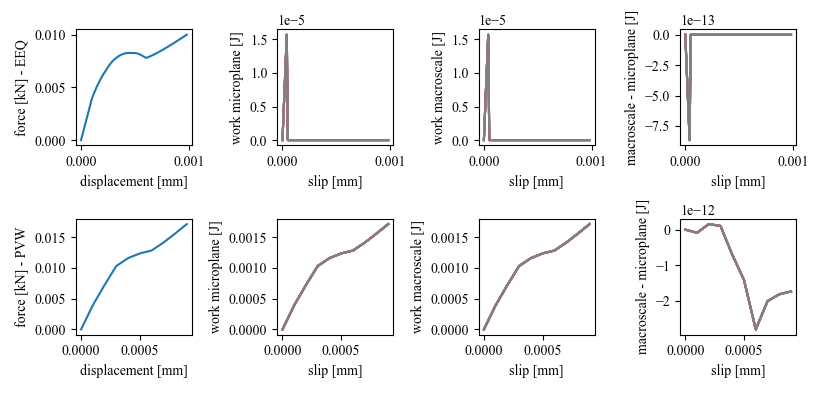

In [71]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(21*cm, 10*cm))
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_tensile)))

ax1.plot(-U_compression_EEQ, -F_compression_EEQ/1000)
ax1.set_ylabel('force [kN] - EEQ', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(-U_compression_EEQ, total_work_microplane_EEQ)
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression_EEQ, total_work_macro_EEQ)
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ)
ax4.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

ax5.plot(-U_compression_PVW, -F_compression_PVW/1000)
ax5.set_ylabel('force [kN] - PVW', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)

ax6.plot(-U_compression_PVW, total_work_microplane_PVW)
ax6.set_ylabel('work microplane [J]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)

ax7.plot(-U_compression_PVW, total_work_macro_PVW)
ax7.set_ylabel('work macroscale [J]', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)

ax8.plot(-U_compression_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax8.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()



fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_compresion'  + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_compresion'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [82]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DEEQ_damage(**mat_param)
m_shear_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [83]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [84]:
w_max = -0.1

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [support, slide_slice, compression_slice, back_side]

In [85]:
m_shear_EEQ.bc=bc1

m_shear_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_shear_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')


computational time: 10.240546464920044 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
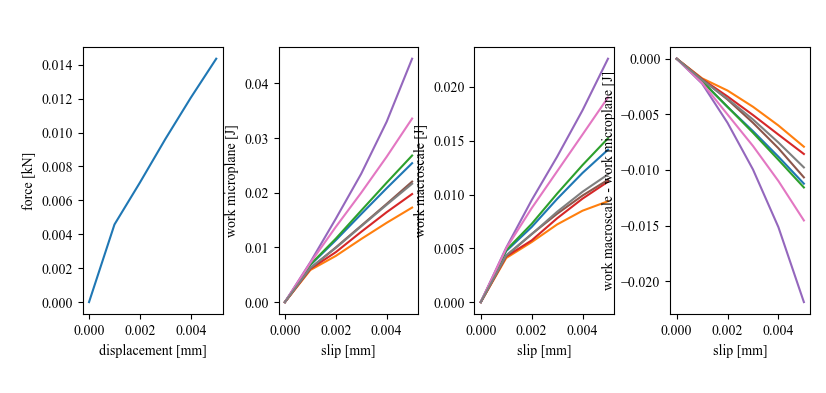

In [86]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_slide_EEQ = np.average(m_shear_EEQ.hist.U_t[:, slide_dofs], axis=-1)
F_slide_EEQ = np.sum(m_shear_EEQ.hist.F_t[:, slide_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_compression)))

ax1.plot(-U_slide_EEQ, -F_slide_EEQ/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_EEQ = np.zeros((len(m_shear_EEQ.hist.state_vars),8))
total_work_macro_EEQ = np.zeros((len(m_shear_EEQ.hist.state_vars),8))
for i in range(len(U_slide_EEQ)):
    total_work_microplane_EEQ[i] = np.array([ m_shear_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_EEQ[i] = np.array([ m_shear_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_slide_EEQ, total_work_microplane_EEQ, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_EEQ, total_work_macro_EEQ, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Unit element shear - PVW

In [89]:
w_max = -0.05

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [support, slide_slice, compression_slice, back_side]

In [90]:
m_shear_PVW.bc=bc1

m_shear_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_shear_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\ms1_sigma_pvw_damage.py:228: RuntimeWarning: overflow encountered in multiply
  sigma_N_Emn[...] = (1 - omega_N_Emn) * E_N * eps_N_Emn



computational time: 10.909200191497803 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
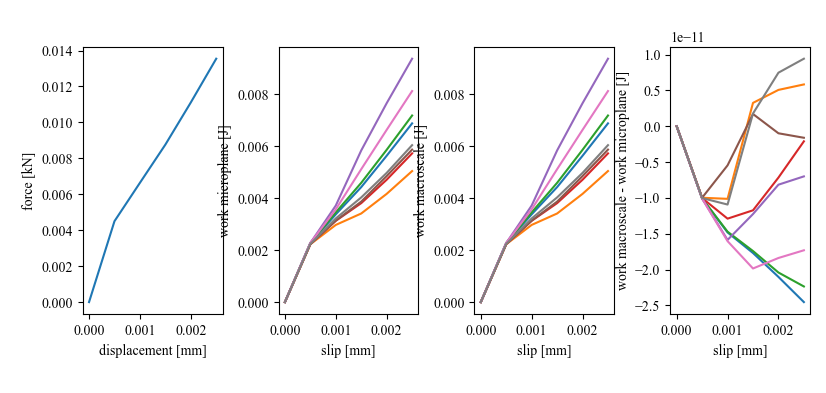

In [93]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_slide_PVW = np.average(m_shear_PVW.hist.U_t[:, slide_dofs], axis=-1)
F_slide_PVW = np.sum(m_shear_PVW.hist.F_t[:, slide_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_slide_PVW, -F_slide_PVW/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_shear_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_shear_PVW.hist.state_vars),8))
for i in range(len(U_slide_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_shear_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_shear_PVW.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_slide_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
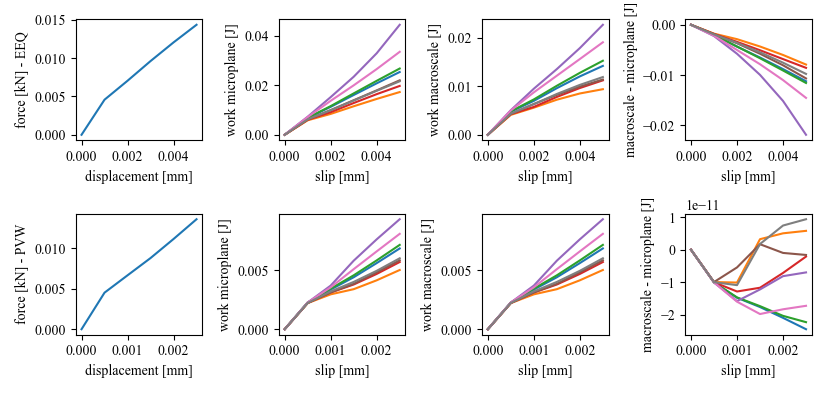

In [94]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(21*cm, 10*cm))
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_tensile)))

ax1.plot(-U_slide_EEQ, -F_slide_EEQ/1000)
ax1.set_ylabel('force [kN] - EEQ', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(-U_slide_EEQ, total_work_microplane_EEQ)
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_EEQ, total_work_macro_EEQ)
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ)
ax4.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

ax5.plot(-U_slide_PVW, -F_slide_PVW/1000)
ax5.set_ylabel('force [kN] - PVW', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)

ax6.plot(-U_slide_PVW, total_work_microplane_PVW)
ax6.set_ylabel('work microplane [J]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)

ax7.plot(-U_slide_PVW, total_work_macro_PVW)
ax7.set_ylabel('work macroscale [J]', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)

ax8.plot(-U_slide_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax8.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()



fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_shear'  + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_shear'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [96]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DEEQ_damage(**mat_param)
m_tension_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [97]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [98]:
w_max = 0.001

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [99]:
m_tension_EEQ.bc=bc1

m_tension_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_tension_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 4.776152610778809 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
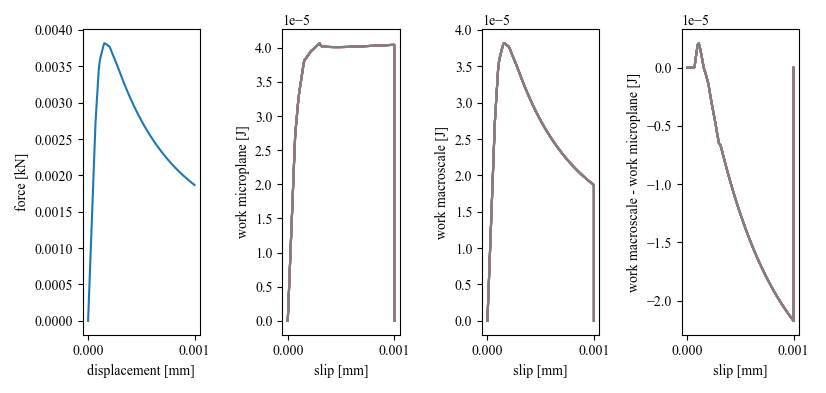

In [100]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_tensile_EEQ = np.average(m_tension_EEQ.hist.U_t[:, compression_dofs], axis=-1)
F_tensile_EEQ = np.sum(m_tension_EEQ.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_tensile_EEQ)))

ax1.plot(U_tensile_EEQ, F_tensile_EEQ/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_EEQ = np.zeros((len(m_tension_EEQ.hist.state_vars),8))
total_work_macro_EEQ = np.zeros((len(m_tension_EEQ.hist.state_vars),8))
for i in range(len(U_tensile_EEQ)):
    total_work_microplane_EEQ[i] = np.array([ m_tension_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_EEQ[i] = np.array([ m_tension_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(U_tensile_EEQ, total_work_microplane_EEQ, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile_EEQ, total_work_macro_EEQ, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [101]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW_damage(**mat_param)
m_tension_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [102]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [103]:
w_max = 0.001

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [104]:
m_tension_PVW.bc=bc1

m_tension_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_tension_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
# s.run()
start = time.time()
s.run()
# try:
#     s.run()
# except:
#     # m_list_monotnonic.append(m)
#     pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\ms1_sigma_pvw_damage.py:228: RuntimeWarning: overflow encountered in multiply
  sigma_N_Emn[...] = (1 - omega_N_Emn) * E_N * eps_N_Emn


StopIteration: Warning: convergence not reached in 1000 iterations

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
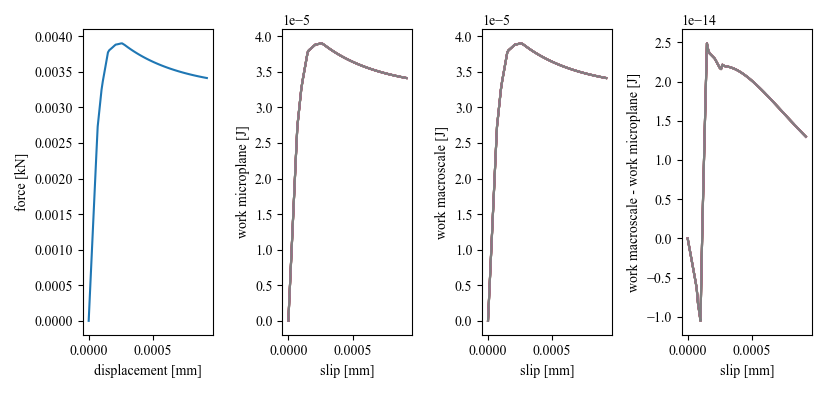

In [105]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_tensile_PVW = np.average(m_tension_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_tensile_PVW = np.sum(m_tension_PVW.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_tensile_PVW)))

ax1.plot(U_tensile_PVW, F_tensile_PVW/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_tension_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_tension_PVW.hist.state_vars),8))
for i in range(len(U_tensile_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_macro']])

# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax2.plot(U_tensile_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
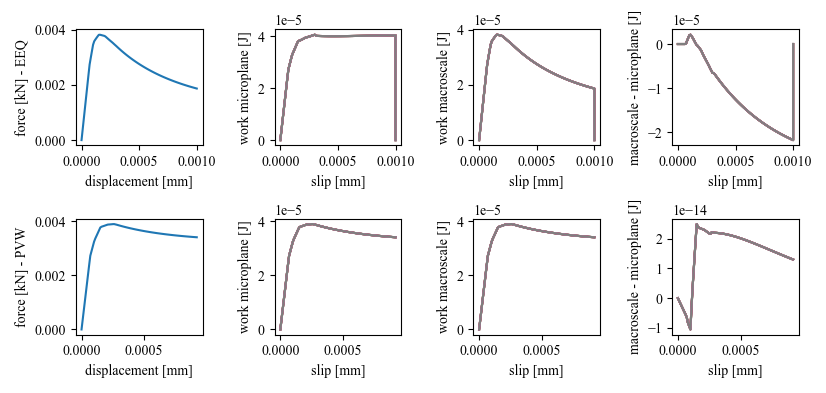

In [106]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(21*cm, 10*cm))
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_tensile)))

ax1.plot(U_tensile_EEQ, F_tensile_EEQ/1000)
ax1.set_ylabel('force [kN] - EEQ', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(U_tensile_EEQ, total_work_microplane_EEQ)
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile_EEQ, total_work_macro_EEQ)
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ)
ax4.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

ax5.plot(U_tensile_PVW, F_tensile_PVW/1000)
ax5.set_ylabel('force [kN] - PVW', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)

ax6.plot(U_tensile_PVW, total_work_microplane_PVW)
ax6.set_ylabel('work microplane [J]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)

ax7.plot(U_tensile_PVW, total_work_macro_PVW)
ax7.set_ylabel('work macroscale [J]', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)

ax8.plot(U_tensile_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax8.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()



fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_tangential_tension'  + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_tangential_tension'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [107]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DEEQ_damage(**mat_param)
m_compression_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [108]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [109]:
w_max = -0.001

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [110]:
m_compression_EEQ.bc=bc1

m_compression_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_compression_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 7.244080305099487 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
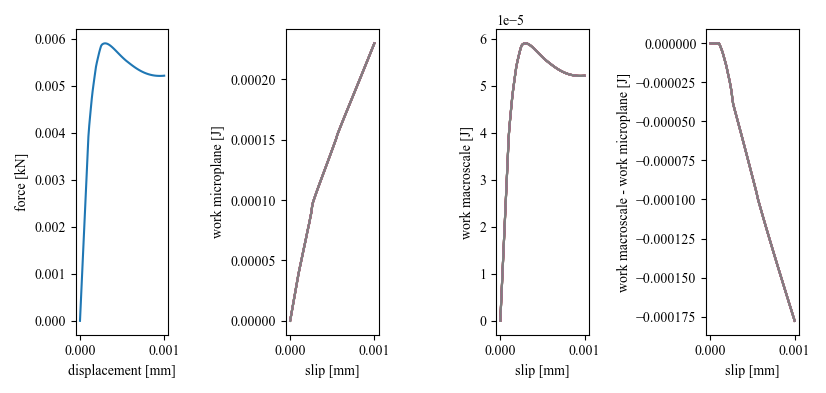

In [111]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_compression_EEQ = np.average(m_compression_EEQ.hist.U_t[:, compression_dofs], axis=-1)
F_compression_EEQ = np.sum(m_compression_EEQ.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_compression)))

ax1.plot(-U_compression_EEQ, -F_compression_EEQ/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_EEQ = np.zeros((len(m_compression_EEQ.hist.state_vars),8))
total_work_macro_EEQ = np.zeros((len(m_compression_EEQ.hist.state_vars),8))
for i in range(len(U_compression_EEQ)):
    total_work_microplane_EEQ[i] = np.array([ m_compression_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_EEQ[i] = np.array([ m_compression_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_compression_EEQ, total_work_microplane_EEQ, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression_EEQ, total_work_macro_EEQ, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [112]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW_damage(**mat_param)
m_compression_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [113]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [114]:
w_max = -0.01

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [115]:
m_compression_PVW.bc=bc1

m_compression_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_compression_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
# s.run()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\ms1_sigma_pvw_damage.py:228: RuntimeWarning: overflow encountered in multiply
  sigma_N_Emn[...] = (1 - omega_N_Emn) * E_N * eps_N_Emn



computational time: 10.873663902282715 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
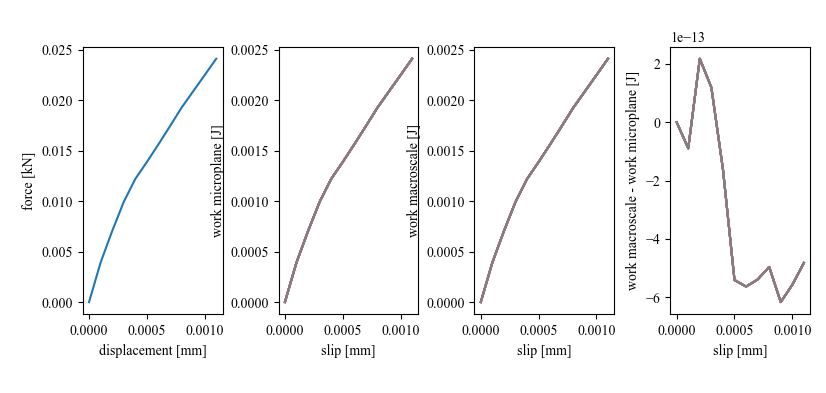

In [116]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_compression_PVW = np.average(m_compression_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_compression_PVW = np.sum(m_compression_PVW.hist.F_t[:, compression_dofs], axis=-1)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_compression_PVW, -F_compression_PVW/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_compression_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_compression_PVW.hist.state_vars),8))
for i in range(len(U_compression_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_compression_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_compression_PVW.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_compression_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
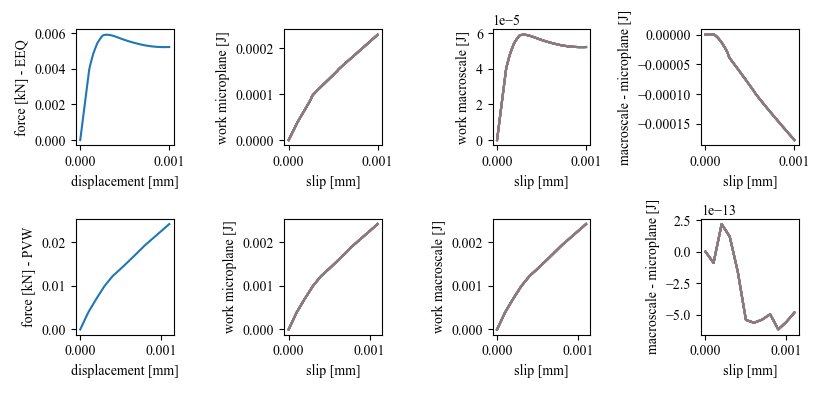

In [117]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(21*cm, 10*cm))
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_tensile)))

ax1.plot(-U_compression_EEQ, -F_compression_EEQ/1000)
ax1.set_ylabel('force [kN] - EEQ', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(-U_compression_EEQ, total_work_microplane_EEQ)
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression_EEQ, total_work_macro_EEQ)
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ)
ax4.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

ax5.plot(-U_compression_PVW, -F_compression_PVW/1000)
ax5.set_ylabel('force [kN] - PVW', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)

ax6.plot(-U_compression_PVW, total_work_microplane_PVW)
ax6.set_ylabel('work microplane [J]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)

ax7.plot(-U_compression_PVW, total_work_macro_PVW)
ax7.set_ylabel('work macroscale [J]', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)

ax8.plot(-U_compression_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax8.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()



fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_tangential_compresion'  + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_tangential_compresion'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [118]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DEEQ_damage(**mat_param)
m_shear_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [119]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [120]:
w_max = -0.1

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [support, slide_slice, compression_slice, back_side]

In [121]:
m_shear_EEQ.bc=bc1

m_shear_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_shear_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')


computational time: 10.277899026870728 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
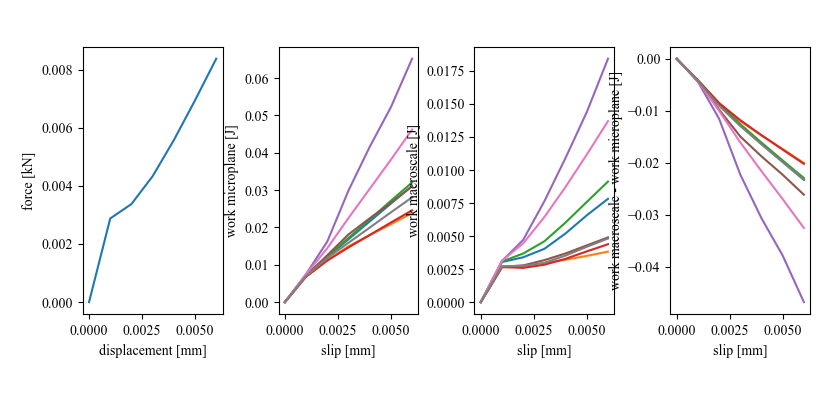

In [122]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_slide_EEQ = np.average(m_shear_EEQ.hist.U_t[:, slide_dofs], axis=-1)
F_slide_EEQ = np.sum(m_shear_EEQ.hist.F_t[:, slide_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_compression)))

ax1.plot(-U_slide_EEQ, -F_slide_EEQ/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_EEQ = np.zeros((len(m_shear_EEQ.hist.state_vars),8))
total_work_macro_EEQ = np.zeros((len(m_shear_EEQ.hist.state_vars),8))
for i in range(len(U_slide_EEQ)):
    total_work_microplane_EEQ[i] = np.array([ m_shear_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_EEQ[i] = np.array([ m_shear_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_slide_EEQ, total_work_microplane_EEQ, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_EEQ, total_work_macro_EEQ, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [123]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW_damage(**mat_param)
m_shear_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [124]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [125]:
w_max = -0.05

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [support, slide_slice, compression_slice, back_side]

In [126]:
m_shear_PVW.bc=bc1

m_shear_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_shear_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')


computational time: 12.554663181304932 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
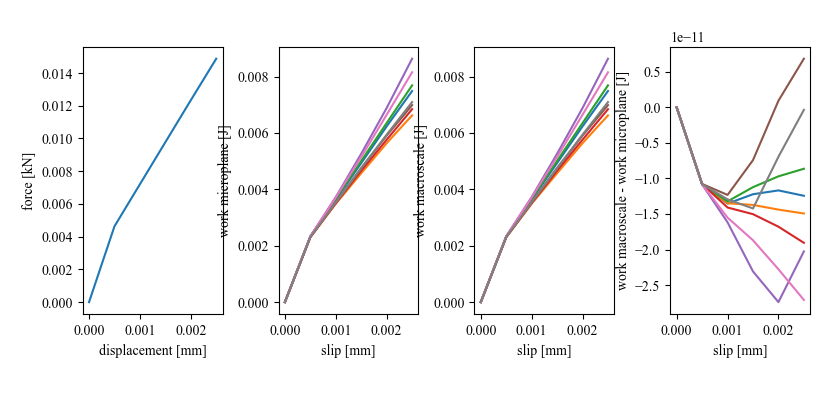

In [127]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_slide_PVW = np.average(m_shear_PVW.hist.U_t[:, slide_dofs], axis=-1)
F_slide_PVW = np.sum(m_shear_PVW.hist.F_t[:, slide_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_slide_PVW, -F_slide_PVW/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_shear_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_shear_PVW.hist.state_vars),8))
for i in range(len(U_slide_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_shear_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_shear_PVW.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_slide_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
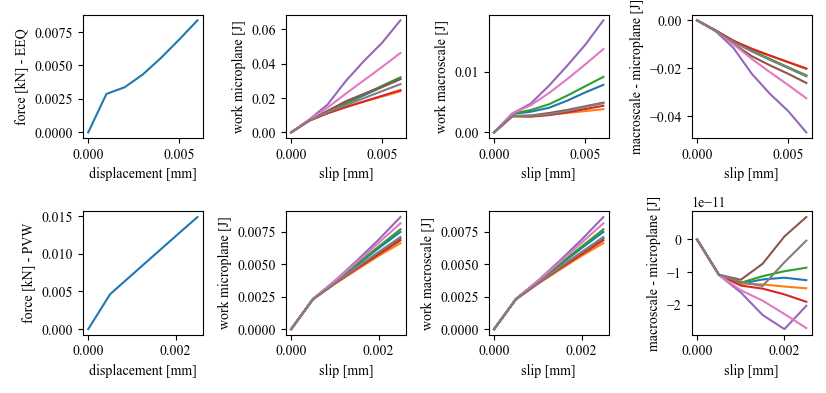

In [128]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(21*cm, 10*cm))
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_tensile)))

ax1.plot(-U_slide_EEQ, -F_slide_EEQ/1000)
ax1.set_ylabel('force [kN] - EEQ', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(-U_slide_EEQ, total_work_microplane_EEQ)
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_EEQ, total_work_macro_EEQ)
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ)
ax4.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

ax5.plot(-U_slide_PVW, -F_slide_PVW/1000)
ax5.set_ylabel('force [kN] - PVW', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)

ax6.plot(-U_slide_PVW, total_work_microplane_PVW)
ax6.set_ylabel('work microplane [J]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)

ax7.plot(-U_slide_PVW, total_work_macro_PVW)
ax7.set_ylabel('work macroscale [J]', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)

ax8.plot(-U_slide_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax8.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()



fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_tangential_shear'  + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_tangential_shear'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [129]:
# Reference parameters

mat_param = dict(
    E = 39226,
    nu = 0.18,
    eps_0 = 59.0e-6,
    epsilon_f = 250.0e-6,
    eps_0_t = 59.0e-6,
    epsilon_f_t = 250.0e-6
)

### Unit element tension - EEQ

In [130]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DEEQ_damage(**mat_param)
m_tension_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [131]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [132]:
w_max = 0.001

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [133]:
m_tension_EEQ.bc=bc1

m_tension_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_tension_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 5.360847234725952 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
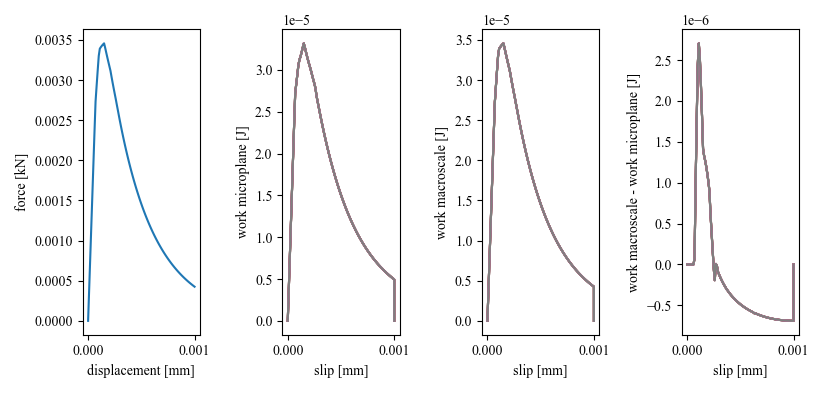

In [134]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_tensile_EEQ = np.average(m_tension_EEQ.hist.U_t[:, compression_dofs], axis=-1)
F_tensile_EEQ = np.sum(m_tension_EEQ.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_tensile_EEQ)))

ax1.plot(U_tensile_EEQ, F_tensile_EEQ/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_EEQ = np.zeros((len(m_tension_EEQ.hist.state_vars),8))
total_work_macro_EEQ = np.zeros((len(m_tension_EEQ.hist.state_vars),8))
for i in range(len(U_tensile_EEQ)):
    total_work_microplane_EEQ[i] = np.array([ m_tension_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_EEQ[i] = np.array([ m_tension_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(U_tensile_EEQ, total_work_microplane_EEQ, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile_EEQ, total_work_macro_EEQ, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Unit element tension - PVW

In [135]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW_damage(**mat_param)
m_tension_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [136]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [137]:
w_max = 0.001

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [138]:
m_tension_PVW.bc=bc1

m_tension_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_tension_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
# s.run()
start = time.time()
s.run()
# try:
#     s.run()
# except:
#     # m_list_monotnonic.append(m)
#     pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\ms1_sigma_pvw_damage.py:228: RuntimeWarning: overflow encountered in multiply
  sigma_N_Emn[...] = (1 - omega_N_Emn) * E_N * eps_N_Emn


StopIteration: Warning: convergence not reached in 1000 iterations

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
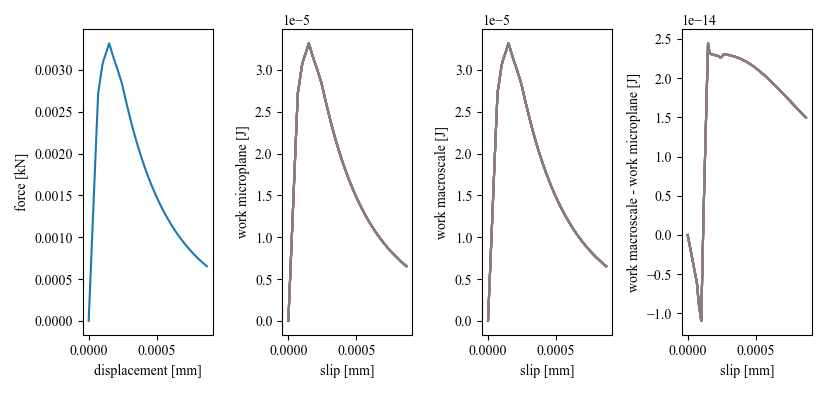

In [140]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_tensile_PVW = np.average(m_tension_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_tensile_PVW = np.sum(m_tension_PVW.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_tensile_PVW)))

ax1.plot(U_tensile_PVW, F_tensile_PVW/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_tension_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_tension_PVW.hist.state_vars),8))
for i in range(len(U_tensile_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_macro']])

# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax2.plot(U_tensile_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Summary tension

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
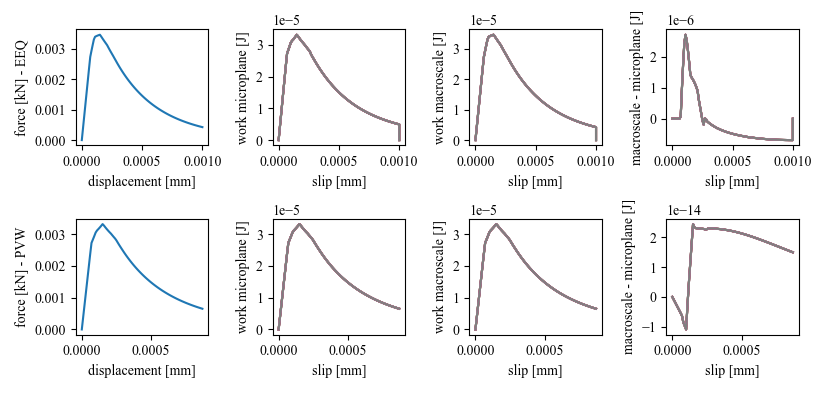

In [141]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(21*cm, 10*cm))
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_tensile)))

ax1.plot(U_tensile_EEQ, F_tensile_EEQ/1000)
ax1.set_ylabel('force [kN] - EEQ', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(U_tensile_EEQ, total_work_microplane_EEQ)
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile_EEQ, total_work_macro_EEQ)
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ)
ax4.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

ax5.plot(U_tensile_PVW, F_tensile_PVW/1000)
ax5.set_ylabel('force [kN] - PVW', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)

ax6.plot(U_tensile_PVW, total_work_microplane_PVW)
ax6.set_ylabel('work microplane [J]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)

ax7.plot(U_tensile_PVW, total_work_macro_PVW)
ax7.set_ylabel('work macroscale [J]', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)

ax8.plot(U_tensile_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax8.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()



fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_tangential_tension'  + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_tangential_tension'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Unit element compression - EEQ

In [142]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DEEQ_damage(**mat_param)
m_compression_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [143]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [144]:
w_max = -0.001

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [145]:
m_compression_EEQ.bc=bc1

m_compression_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_compression_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 6.6102025508880615 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
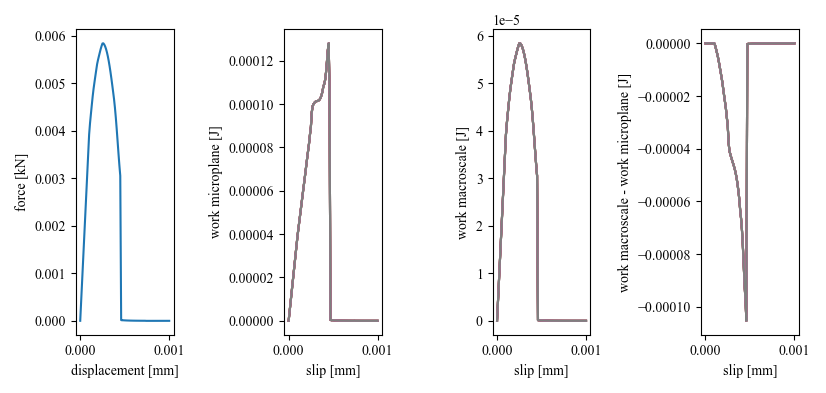

In [146]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_compression_EEQ = np.average(m_compression_EEQ.hist.U_t[:, compression_dofs], axis=-1)
F_compression_EEQ = np.sum(m_compression_EEQ.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_compression)))

ax1.plot(-U_compression_EEQ, -F_compression_EEQ/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_EEQ = np.zeros((len(m_compression_EEQ.hist.state_vars),8))
total_work_macro_EEQ = np.zeros((len(m_compression_EEQ.hist.state_vars),8))
for i in range(len(U_compression_EEQ)):
    total_work_microplane_EEQ[i] = np.array([ m_compression_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_EEQ[i] = np.array([ m_compression_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_compression_EEQ, total_work_microplane_EEQ, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression_EEQ, total_work_macro_EEQ, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Unit element compression - PVW

In [147]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW_damage(**mat_param)
m_compression_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [148]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [149]:
w_max = -0.01

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [150]:
m_compression_PVW.bc=bc1

m_compression_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_compression_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
# s.run()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\ms1_sigma_pvw_damage.py:271: RuntimeWarning: overflow encountered in true_divide
  np.exp(-1.0 * (kappa_n[I] - epsilon_0) /
c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\ms1_sigma_pvw_damage.py:228: RuntimeWarning: overflow encountered in multiply
  sigma_N_Emn[...] = (1 - omega_N_Emn) * E_N * eps_N_Emn



computational time: 10.084224939346313 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
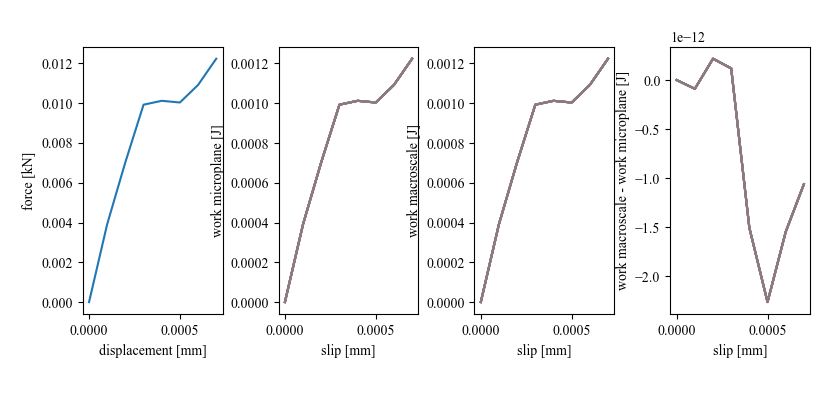

In [151]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_compression_PVW = np.average(m_compression_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_compression_PVW = np.sum(m_compression_PVW.hist.F_t[:, compression_dofs], axis=-1)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_compression_PVW, -F_compression_PVW/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_compression_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_compression_PVW.hist.state_vars),8))
for i in range(len(U_compression_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_compression_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_compression_PVW.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_compression_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Summary compression

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
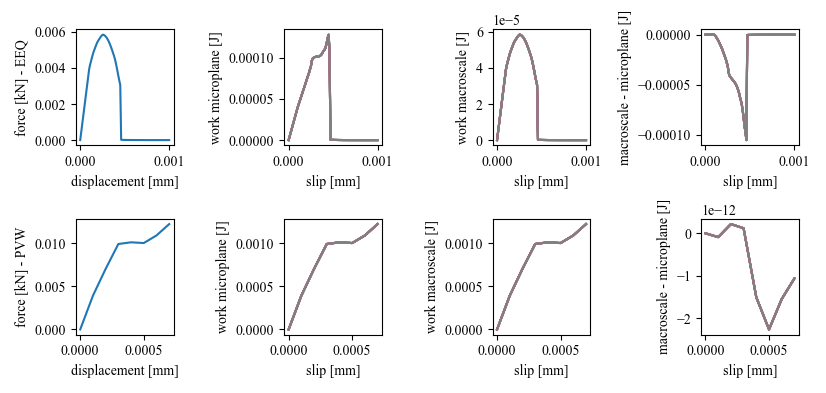

In [152]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(21*cm, 10*cm))
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_tensile)))

ax1.plot(-U_compression_EEQ, -F_compression_EEQ/1000)
ax1.set_ylabel('force [kN] - EEQ', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(-U_compression_EEQ, total_work_microplane_EEQ)
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression_EEQ, total_work_macro_EEQ)
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ)
ax4.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

ax5.plot(-U_compression_PVW, -F_compression_PVW/1000)
ax5.set_ylabel('force [kN] - PVW', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)

ax6.plot(-U_compression_PVW, total_work_microplane_PVW)
ax6.set_ylabel('work microplane [J]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)

ax7.plot(-U_compression_PVW, total_work_macro_PVW)
ax7.set_ylabel('work macroscale [J]', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)

ax8.plot(-U_compression_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax8.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()



fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_tangential_compresion'  + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_tangential_compresion'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Unit element shear - EEQ

In [186]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DEEQ_damage(**mat_param)
m_shear_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [187]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [188]:
w_max = -0.005

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [support, slide_slice, compression_slice, back_side]

In [189]:
m_shear_EEQ.bc=bc1

m_shear_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_shear_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')


computational time: 13.259755849838257 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
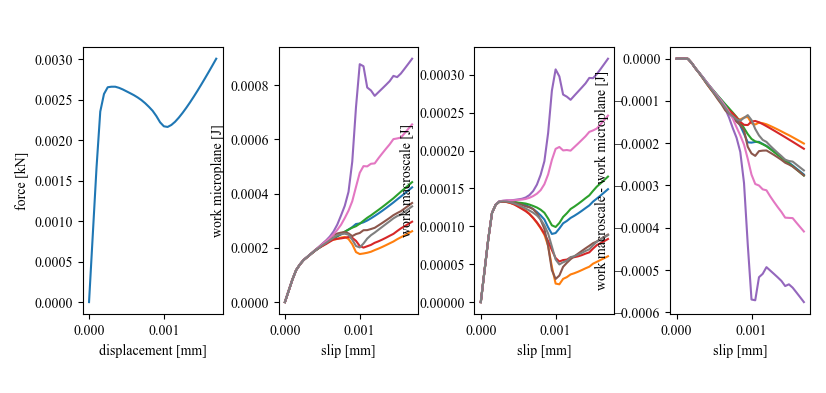

In [190]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_slide_EEQ = np.average(m_shear_EEQ.hist.U_t[:, slide_dofs], axis=-1)
F_slide_EEQ = np.sum(m_shear_EEQ.hist.F_t[:, slide_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_compression)))

ax1.plot(-U_slide_EEQ, -F_slide_EEQ/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_EEQ = np.zeros((len(m_shear_EEQ.hist.state_vars),8))
total_work_macro_EEQ = np.zeros((len(m_shear_EEQ.hist.state_vars),8))
for i in range(len(U_slide_EEQ)):
    total_work_microplane_EEQ[i] = np.array([ m_shear_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_EEQ[i] = np.array([ m_shear_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_slide_EEQ, total_work_microplane_EEQ, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_EEQ, total_work_macro_EEQ, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Unit element shear - PVW

In [207]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW_damage(**mat_param)
m_shear_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [208]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [209]:
w_max = -0.0015

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [support, slide_slice, compression_slice, back_side]

In [210]:
m_shear_PVW.bc=bc1

m_shear_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_shear_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
# s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')


computational time: 20.697258710861206 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
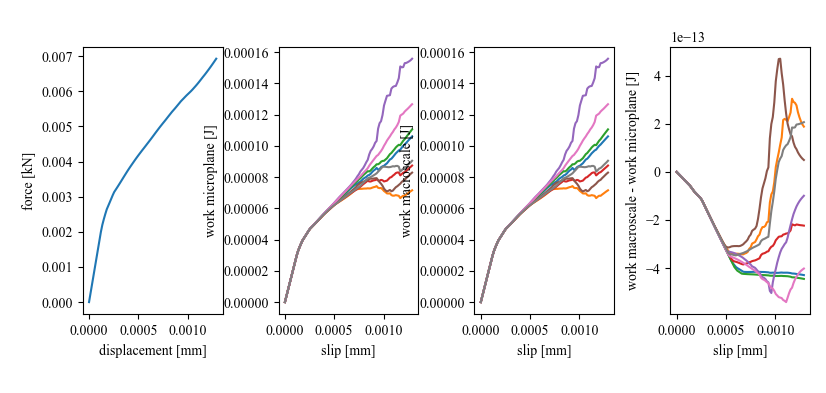

In [211]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_slide_PVW = np.average(m_shear_PVW.hist.U_t[:, slide_dofs], axis=-1)
F_slide_PVW = np.sum(m_shear_PVW.hist.F_t[:, slide_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_slide_PVW, -F_slide_PVW/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane_PVW = np.zeros((len(m_shear_PVW.hist.state_vars),8))
total_work_macro_PVW = np.zeros((len(m_shear_PVW.hist.state_vars),8))
for i in range(len(U_slide_PVW)):
    total_work_microplane_PVW[i] = np.array([ m_shear_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro_PVW[i] = np.array([ m_shear_PVW.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_slide_PVW, total_work_microplane_PVW, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_PVW, total_work_macro_PVW, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_PVW, total_work_macro_PVW - total_work_microplane_PVW, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### Summary shear

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
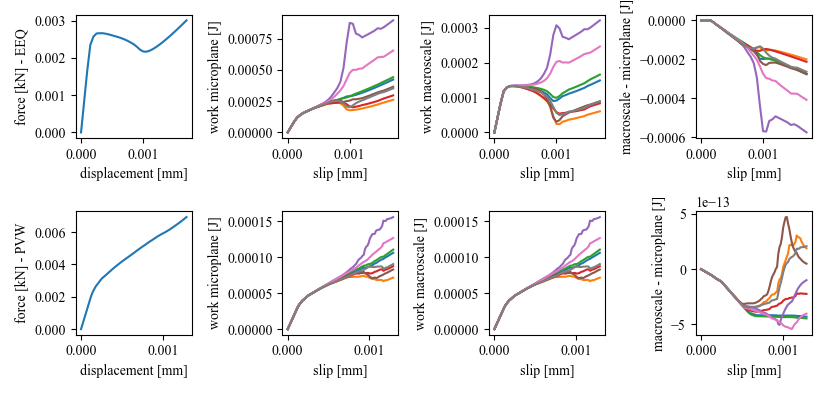

In [212]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
# max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4,figsize=(21*cm, 10*cm))
# total_work_microplane, total_work_macro = get_total_work(m)

# max_F.append(max(abs(F_tensile)))

ax1.plot(-U_slide_EEQ, -F_slide_EEQ/1000)
ax1.set_ylabel('force [kN] - EEQ', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

ax2.plot(-U_slide_EEQ, total_work_microplane_EEQ)
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide_EEQ, total_work_macro_EEQ)
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide_EEQ, total_work_macro_EEQ - total_work_microplane_EEQ)
ax4.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

ax5.plot(-U_slide_PVW, -F_slide_PVW/1000)
ax5.set_ylabel('force [kN] - PVW', fontsize=10)
ax5.set_xlabel('displacement [mm]', fontsize=10)

ax6.plot(-U_slide_PVW, total_work_microplane_PVW)
ax6.set_ylabel('work microplane [J]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)

ax7.plot(-U_slide_PVW, total_work_macro_PVW)
ax7.set_ylabel('work macroscale [J]', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)

ax8.plot(-U_slide_PVW, total_work_macro_PVW - total_work_microplane_PVW)
ax8.set_ylabel('macroscale - microplane [J]', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()



fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_tangential_shear'  + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PAPER Homogenization\\Figures\\Study_0X\\simple_damage\\study0X_damage_normal_tangential_shear'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()